In [0]:
import os 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
from matplotlib.pyplot import imread
import tensorflow

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#!unzip -uq "/content/drive/My Drive/intel-image-classification.zip" -d "/content/drive/My Drive/intel"

In [0]:
data_dir = '/content/drive/My Drive/intel'

In [9]:
test_path = data_dir+'/seg_test/seg_test'
train_path = data_dir+'/seg_train/seg_train'
os.listdir(train_path)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [10]:
os.listdir(train_path+'/buildings/')[1]

'1955.jpg'

In [0]:
building_sample = train_path+'/buildings'+'/10006.jpg'

In [0]:
b_sample_img = imread(building_sample)

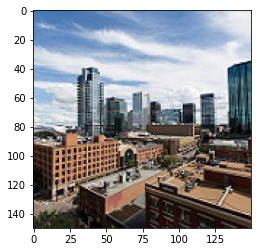

In [13]:
plt.imshow(b_sample_img)

In [14]:
b_sample_img.shape

(150, 150, 3)

In [15]:
print(len(os.listdir(train_path+'/buildings/'))
+len(os.listdir(train_path+'/forest/'))
+len(os.listdir(train_path+'/glacier/'))
+len(os.listdir(train_path+'/mountain/'))
+len(os.listdir(train_path+'/sea/'))
+len(os.listdir(train_path+'/street/')))

12611


In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

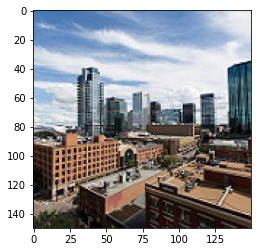

In [18]:
plt.imshow(b_sample_img)

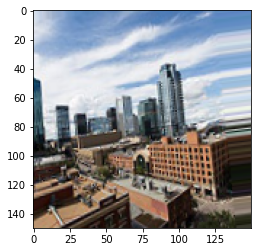

In [19]:
plt.imshow(image_gen.random_transform(b_sample_img))

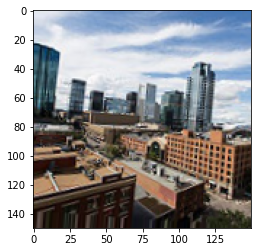

In [20]:
plt.imshow(image_gen.random_transform(b_sample_img))

In [21]:
image_gen.flow_from_directory(train_path)

Found 12611 images belonging to 6 classes.


In [22]:
image_gen.flow_from_directory(test_path)

Found 3000 images belonging to 6 classes.


In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,Activation

In [0]:
pip install -U keras-tuner

Requirement already up-to-date: keras-tuner in /usr/local/lib/python3.6/dist-packages (1.0.1)


In [0]:
def build_model(hp):
  model = Sequential()
  model.add(Conv2D(
      filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
      kernel_size=hp.Choice('conv_1_kernel', values=[3,5]),
      activation='relu',
      input_shape=(150,150,3)))
  model.add(Conv2D(filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=16),
                          kernel_size=hp.Choice('conv_2_kernel', values=[3,5]),
                          activation='relu',
                          input_shape=(150,150,3)))
  model.add(Conv2D(filters=hp.Int('conv_3_filter', min_value=32, max_value=128, step=16),
                          kernel_size=hp.Choice('conv_3_kernel', values=[3,5]),
                          activation='relu',
                          input_shape=(150,150,3)))
  model.add(Conv2D(filters=hp.Int('conv_4_filter', min_value=32, max_value=128, step=16),
                          kernel_size=hp.Choice('conv_4_kernel', values=[3,5]),
                          activation='relu',
                          input_shape=(150,150,3)))
                      
  model.add(Flatten())
  model.add(Dense(units=hp.Int('dense_1_units',min_value=32,max_value=128,step=16),activation='relu')),
  model.add(Dense(6,activation='softmax'))
                     
  model.compile(optimizer=tensorflow.keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])
  return model                      

In [0]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters 

In [0]:
from tensorflow.keras.callbacks import EarlyStopping

In [0]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [0]:
batch_size = 16
image_shape=(150,150,3)

In [26]:
train_gen = image_gen.flow_from_directory(train_path,target_size=image_shape[:2],color_mode='rgb',batch_size=batch_size,
                                                                            class_mode='sparse')

Found 12611 images belonging to 6 classes.


In [27]:
test_gen = image_gen.flow_from_directory(test_path,target_size=image_shape[:2],color_mode='rgb',batch_size=batch_size,
                                         class_mode='sparse',shuffle=False)


Found 3000 images belonging to 6 classes.


In [0]:
train_gen.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [0]:
tuner_search = RandomSearch(build_model,objective='val_acc',max_trials=5,directory='intel-output',project_name='Intel-Image-Classification')

INFO:tensorflow:Reloading Oracle from existing project intel-output/Intel-Image-Classification/oracle.json


In [0]:
tuner_search.search(train_gen,epochs=2,validation_data=test_gen)

Epoch 1/2
789/789 [==============================] - 5570s 7s/step - loss: 1.3632 - acc: 0.5527 - val_loss: 1.0652 - val_acc: 0.5797
Epoch 2/2
789/789 [==============================] - 121s 153ms/step - loss: 0.8937 - acc: 0.6623 - val_loss: 0.9244 - val_acc: 0.6630


Epoch 1/2
789/789 [==============================] - 117s 149ms/step - loss: 1.0206 - acc: 0.6092 - val_loss: 0.9408 - val_acc: 0.6373
Epoch 2/2
789/789 [==============================] - 115s 146ms/step - loss: 0.7761 - acc: 0.7191 - val_loss: 0.8745 - val_acc: 0.6850


Epoch 1/2
789/789 [==============================] - 162s 206ms/step - loss: 39.2757 - acc: 0.1950 - val_loss: 1.8448 - val_acc: 0.1750
Epoch 2/2
789/789 [==============================] - 127s 160ms/step - loss: 1.7566 - acc: 0.1942 - val_loss: 1.8453 - val_acc: 0.1750


Epoch 1/2
789/789 [==============================] - 134s 169ms/step - loss: 223.4768 - acc: 0.1978 - val_loss: 1.8373 - val_acc: 0.1580
Epoch 2/2
789/789 [==============================] - 132s 167ms/step - loss: 1.7561 - acc: 0.1935 - val_loss: 1.8290 - val_acc: 0.1750


Epoch 1/2
789/789 [==============================] - 141s 178ms/step - loss: 2.0592 - acc: 0.1979 - val_loss: 1.8354 - val_acc: 0.1750
Epoch 2/2
789/789 [==============================] - 136s 172ms/step - loss: 1.7556 - acc: 0.1962 - val_loss: 1.8375 - val_acc: 0.1750


INFO:tensorflow:Oracle triggered exit


In [0]:
model=tuner_search.get_best_models(num_models=1)[0]

In [0]:
model.fit_generator(train_gen,epochs=25,validation_data=test_gen,callbacks=[early_stop],initial_epoch=2)

Epoch 3/25
789/789 [==============================] - 129s 163ms/step - loss: 0.6928 - acc: 0.7446 - val_loss: 0.7564 - val_acc: 0.7327
Epoch 4/25
789/789 [==============================] - 118s 150ms/step - loss: 0.6377 - acc: 0.7714 - val_loss: 0.6352 - val_acc: 0.7717
Epoch 5/25
789/789 [==============================] - 119s 151ms/step - loss: 0.5864 - acc: 0.7884 - val_loss: 0.6650 - val_acc: 0.7650
Epoch 6/25
789/789 [==============================] - 119s 151ms/step - loss: 0.5610 - acc: 0.7995 - val_loss: 0.5534 - val_acc: 0.8043
Epoch 7/25
789/789 [==============================] - 119s 151ms/step - loss: 0.5262 - acc: 0.8098 - val_loss: 0.5678 - val_acc: 0.7953
Epoch 8/25
789/789 [==============================] - 115s 146ms/step - loss: 0.5061 - acc: 0.8186 - val_loss: 0.5252 - val_acc: 0.8123
Epoch 9/25
789/789 [==============================] - 115s 146ms/step - loss: 0.4827 - acc: 0.8267 - val_loss: 0.5239 - val_acc: 0.8093
Epoch 10/25
789/789 [===========================

In [0]:
losses = pd.DataFrame(model.history.history)

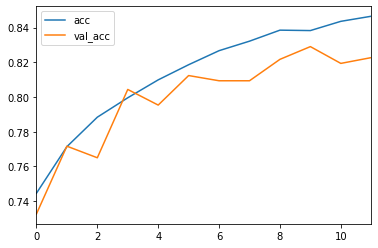

In [0]:
losses[['acc','val_acc']].plot()

In [34]:
pred_test = model.predict_generator(test_gen,verbose=1) 

188/188 [==============================] - 101s 536ms/step


In [0]:
from sklearn.metrics import confusion_matrix,classification_report

In [35]:
pred_test

array([[9.7012168e-01, 2.6679616e-03, 1.7977168e-03, 4.4953550e-04,
        1.6403615e-02, 8.5594682e-03],
       [9.5319587e-01, 4.2513642e-04, 4.7736596e-03, 5.0811563e-04,
        1.3216030e-03, 3.9775643e-02],
       [8.7917215e-01, 1.2071958e-03, 4.9915025e-04, 3.7738795e-03,
        9.1011496e-03, 1.0624656e-01],
       ...,
       [4.5886818e-02, 1.0116075e-02, 2.1060560e-02, 6.6437566e-01,
        2.5830814e-01, 2.5277809e-04],
       [7.2303975e-01, 1.2923147e-03, 7.8837499e-03, 3.6989231e-02,
        9.3668781e-02, 1.3712622e-01],
       [7.9715312e-02, 1.0838924e-02, 1.3089439e-04, 3.5792251e-05,
        1.2371842e-03, 9.0804195e-01]], dtype=float32)

In [0]:
pred = np.argmax(pred_test,axis=1)

In [61]:
pred

array([0, 0, 0, ..., 3, 0, 5])

In [40]:
test_gen.classes

array([0, 0, 0, ..., 5, 5, 5], dtype=int32)

In [62]:
classification_report(test_gen.classes,pred)

'              precision    recall  f1-score   support\n\n           0       0.69      0.90      0.78       437\n           1       0.95      0.95      0.95       474\n           2       0.78      0.83      0.81       553\n           3       0.82      0.73      0.78       525\n           4       0.84      0.85      0.85       510\n           5       0.92      0.70      0.80       501\n\n    accuracy                           0.82      3000\n   macro avg       0.83      0.83      0.83      3000\nweighted avg       0.83      0.82      0.82      3000\n'

In [64]:
confusion_matrix(test_gen.classes,pred)

array([[392,   5,   4,   4,   7,  25],
       [ 11, 452,   3,   6,   1,   1],
       [ 16,   4, 459,  53,  17,   4],
       [ 13,   2,  76, 385,  48,   1],
       [ 13,   3,  42,  16, 435,   1],
       [122,  11,   3,   3,  10, 352]])

In [0]:
pred_path = data_dir+'/seg_pred/seg_pred'
pred_images = np.array(pred_path)

In [67]:
os.listdir(pred_path)[0]

'8489.jpg'

In [0]:
a =imread(pred_path+'/8489.jpg')

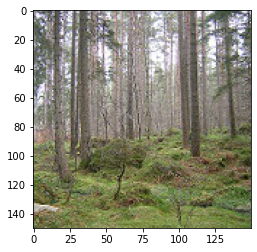

In [73]:
plt.imshow(a)

In [0]:
from tensorflow.keras.preprocessing import image

In [0]:
my_img = image.img_to_array(a)

In [76]:
type(my_img)

numpy.ndarray

In [77]:
my_img.shape

(150, 150, 3)

In [0]:
my_img = np.expand_dims(my_img,axis=0)

In [79]:
my_img.shape

(1, 150, 150, 3)

In [0]:
img_predictions = model.predict(my_img)

In [0]:
img_pred = np.argmax(img_predictions,axis=1)

In [84]:
img_pred

array([1])

In [85]:
train_gen.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}